# Setup

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import numpy as np
import os

2023-11-15 09:17:20.821223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 09:17:20.922969: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 09:17:21.440538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-15 09:17:21.440597: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
DIR_AMAZON = "office31/amazon"
DIR_DSLR = "office31/dslr"
DIR_WEBCAM = "office31/webcam"

In [3]:
BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DIM = 3

EPOCHS = 100

W_CATEGORICAL = 0.1
W_ADVERSARIAL = 0
W_DOMAIN      = 1

SOURCE = DIR_DSLR
TARGET = DIR_WEBCAM

latent_dim = 128

# Preparation Part

In [4]:
dataset_source = tf.keras.utils.image_dataset_from_directory(
  SOURCE,                                                     # change DIR according to the dataset
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 498 files belonging to 31 classes.
Using 399 files for training.


2023-11-15 09:17:22.090417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 09:17:22.677958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21881 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:37:00.0, compute capability: 7.5


In [5]:
dataset_source_val = tf.keras.utils.image_dataset_from_directory(
  SOURCE,                                                     # change DIR according to the dataset
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 498 files belonging to 31 classes.
Using 99 files for validation.


In [6]:
dataset_target = tf.keras.utils.image_dataset_from_directory(
  TARGET,                                                     # change DIR according to the dataset
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 795 files belonging to 31 classes.


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

dataset_source = dataset_source.map(lambda x, y: (normalization_layer(x), y))
dataset_source_val = dataset_source_val.map(lambda x, y: (normalization_layer(x), y))
dataset_target = dataset_target.map(lambda x, y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
dataset = tf.data.Dataset.zip((dataset_source, dataset_source_val, dataset_target))

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  IMG_DIM)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1))
  ]
)

In [10]:
feature_extractor = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DIM),
    include_top=False)

feature_extractor.trainable = False

feature_extractor = keras.Sequential(
    [
        # data_augmentation,
        feature_extractor,
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),

    ],
    name="feature_extractor",
)

In [12]:
for x, y in dataset_source.take(1):
  features = feature_extractor(x)

2023-11-15 09:17:27.509882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-11-15 09:17:28.032853: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [13]:
categorical_classifier = keras.Sequential(
    [
        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.3),
        layers.Dense(31, activation='softmax'),
    ],
    name="categorical_classifier",
)
cls = categorical_classifier(features)


Model: "categorical_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (64, 128)                 65664     
                                                                 
 dropout_1 (Dropout)         (64, 128)                 0         
                                                                 
 dense_2 (Dense)             (64, 31)                  3999      
                                                                 
Total params: 69,663
Trainable params: 69,663
Non-trainable params: 0
_________________________________________________________________


In [14]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [15]:
domain_classifier = keras.Sequential(
    [
        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.Dropout(0.3),
        GradReverse(),
        layers.Dense(1),
    ],
    name="domain_classifier",
)
feature_maps = domain_classifier(features)


Model: "domain_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (64, 128)                 65664     
                                                                 
 dropout_2 (Dropout)         (64, 128)                 0         
                                                                 
 grad_reverse (GradReverse)  (64, 128)                 0         
                                                                 
 dense_4 (Dense)             (64, 1)                   129       
                                                                 
Total params: 65,793
Trainable params: 65,793
Non-trainable params: 0
_________________________________________________________________


In [16]:
discriminator = keras.Sequential(
    [
        # layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        # layers.Dropout(0.3),
        layers.Dense(1),
    ],
    name="discriminator",
)
disc = discriminator(features)


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (64, 1)                   513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [17]:

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(8 * 8 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (8, 8), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

gen_data = generator(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
# gen_data.shape

TensorShape([64, 128, 128, 3])

In [18]:
def total_loss(predictions_disc, labels, predictions_clas, real_label):
    loss1 = loss_fn(labels, predictions_disc)
    loss2 = loss_fn_cls(real_label, predictions_clas)
    return .5 * loss1  + .5 * loss2

In [19]:
# THE OG

# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam()
g_optimizer = keras.optimizers.Adam()
c_optimizer = keras.optimizers.Adam()
fe_optimizer = keras.optimizers.Adam()
domain_optimizer = keras.optimizers.Adam()

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn_cls = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

val_accuracy = tf.keras.metrics.Accuracy()
train_accuracy = tf.keras.metrics.Accuracy()
target_accuracy = tf.keras.metrics.Accuracy()


@tf.function
def train_step(real_images, real_label, test_images, test_label, target_images, target_label):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((BATCH_SIZE, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    combined_domain = tf.concat([target_images, real_images], axis=0)

    # Assemble labels classifying target from source images
    labels_domain = tf.concat(
        [tf.ones((target_images.shape[0], 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels_domain += 0.05 * tf.random.uniform(labels_domain.shape)



    # Train the discriminator
    with tf.GradientTape(persistent=True) as tape:
        features = feature_extractor(combined_images)
        predictions_disc = discriminator(features)
        # predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions_disc)

        features = feature_extractor(real_images)
        predictions_clas = categorical_classifier(features)
        # predictions = classifier(real_images)
        c_loss = loss_fn_cls(real_label, predictions_clas)

        features = feature_extractor(combined_domain)
        predictions_domain = domain_classifier(features)
        domain_loss = loss_fn(labels_domain, predictions_domain)
        domain_loss = -1 * domain_loss

        # fe_loss = total_loss(predictions_disc, labels, predictions_clas, real_label)
        fe_loss = W_ADVERSARIAL * d_loss + W_CATEGORICAL * c_loss + W_DOMAIN * domain_loss

    grads_feature_extractor = tape.gradient(fe_loss, feature_extractor.trainable_weights)
    fe_optimizer.apply_gradients(zip(grads_feature_extractor, feature_extractor.trainable_weights))

    grads_discriminator = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

    grads_categorical = tape.gradient(c_loss, categorical_classifier.trainable_weights)
    c_optimizer.apply_gradients(zip(grads_categorical, categorical_classifier.trainable_weights))

    grads_domain = tape.gradient(domain_loss, domain_classifier.trainable_weights)
    domain_optimizer.apply_gradients(zip(grads_domain, domain_classifier.trainable_weights))



    #################################

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((BATCH_SIZE, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        features = feature_extractor(generator(random_latent_vectors))
        predictions = discriminator(features)
        # predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))


    c_acc_t = train_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(real_images)), 1) , real_label)
    c_acc_v = val_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(test_images)), 1), test_label)
    c_acc_target = target_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(target_images)), 1), target_label)

    return c_acc_target, c_acc_v, c_acc_t, domain_loss, c_loss, d_loss, g_loss, fe_loss

In [21]:
def plot_loss_values(gl_, al_, cl_, dl_, tl_):
  x = np.arange(len(gl_))

  plt.plot(x, gl_, label = "generative loss", linestyle="-.")
  plt.plot(x, al_, label = "adversarial loss", linestyle="-")
  plt.plot(x, cl_, label = "categorical loss", linestyle="--")
  plt.plot(x, dl_, label = "domain loss", linestyle=":")
  plt.plot(x, tl_, label = "total loss", linestyle=(0, (3, 1, 1, 1)))
  plt.legend()
  plt.show()

In [22]:
def plot_acc_values(acc_source_, acc_target_, acc_source_val_):
  x = np.arange(len(acc_source_))
  plt.plot(x, acc_source_, label = "source acc", linestyle="-")
  plt.plot(x, acc_target_, label = "target acc", linestyle=":")
  plt.plot(x, acc_source_val_, label = "val acc", linestyle="-.")
  plt.legend()
  plt.show()

# Training Part

Epoch:  3

domain loss at step 1: -0.798
discriminator loss at step 1: 0.917
adversarial loss at step 1: 0.249
categorical loss at step 1: 3.280

categorical train Accu at step 1: 0.166
categorical val Accu at step 1: 0.104
categorical target Accu at step 1: 0.061


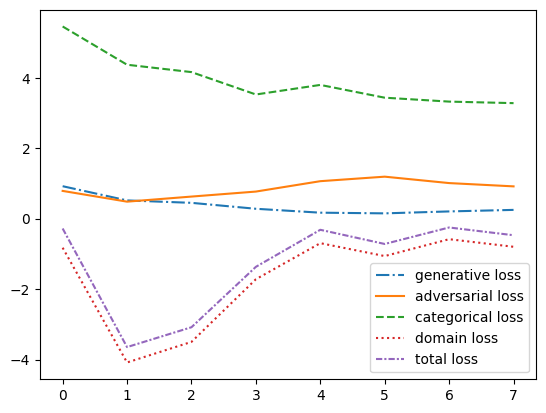

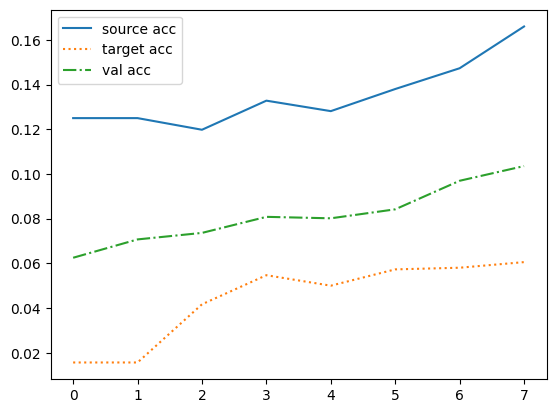

KeyboardInterrupt: 

In [23]:
gl_, al_, cl_, dl_, tl_, acc_source_, acc_target_, acc_source_val_ = [], [], [], [], [], [], [], []

for epoch in range(EPOCHS):


    for step, ((real_images, real_label), (test_images, test_label), (target_images, target_label)) in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        acc_target, acc_source_val, acc_source, domain_loss, categorical_loss, adversarial_loss, generative_loss, fe_loss = train_step(real_images, real_label, test_images, test_label, target_images, target_label)

        gl_ += [generative_loss]
        al_ += [adversarial_loss]
        cl_ += [categorical_loss]
        dl_ += [domain_loss]
        tl_ += [fe_loss]
        acc_source_ += [acc_source]
        acc_target_ += [acc_target]
        acc_source_val_ +=[acc_source_val]

        # Logging.
#         if step % 50 == 0:
#             # Print metrics
    clear_output(wait=True)
    print("Epoch: ", epoch)
    print("\ndomain loss at step %d: %.3f" % (step, domain_loss))
    print("discriminator loss at step %d: %.3f" % (step, adversarial_loss))
    print("adversarial loss at step %d: %.3f" % (step, generative_loss))
    print("categorical loss at step %d: %.3f" % (step, categorical_loss))
    print("\ncategorical train Accu at step %d: %.3f" % (step, acc_source))
    print("categorical val Accu at step %d: %.3f" % (step, acc_source_val))
    print("categorical target Accu at step %d: %.3f" % (step, acc_target))

    plot_loss_values(gl_, al_, cl_, dl_, tl_)
    plot_acc_values(acc_source_, acc_target_, acc_source_val_)


In [ ]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
generated_images = generator(random_latent_vectors)
plt.imshow(generated_images[0])